# Cell 1
#Required dependencies


In [ ]:
!git clone https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch.git
!mkdir data
!mv Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/testing/* data/
!mv Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/training/* data/

!apt install -y libboost-all-dev
!pip install -U pip
!pip install "pybind11[global]"

!pip install aijack

fatal: destination path 'Facial-Similarity-with-Siamese-Networks-in-Pytorch' already exists and is not an empty directory.
mkdir: cannot create directory ‘data’: File exists
mv: cannot stat 'Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/testing/*': No such file or directory
mv: cannot stat 'Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/training/*': No such file or directory
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-all-dev is already the newest version (1.71.0.0ubuntu2).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi

# Cell 2
#Imports

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

from aijack.attack import MI_FACE
from aijack.defense import GeneralMomentAccountant, DPSGDManager
from aijack.utils import NumpyDataset

BASE = "data/" # Modify to your path
path = "/content/drive/MyDrive/MLP_Results/" # Modify to your path

# Cell 3
#Loading data

In [ ]:
imgs = []
labels = []
for i in range(1, 41):
    for j in range(1, 8):
        img = cv2.imread(BASE + f"s{i}/{j}.pgm", 0)
        imgs.append(img)
        labels.append(i - 1)

X = np.stack(imgs)
y = np.array(labels)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = NumpyDataset(X, y, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)


del X
del y


for i in range(1, 41):
    for j in range(8,11):
        img = cv2.imread(BASE + f"s{i}/{j}.pgm", 0)
        imgs.append(img)
        labels.append(i - 1)

X = np.stack(imgs)
y = np.array(labels)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
testset = NumpyDataset(X, y, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=True, num_workers=2
)

# Cell 4
#Creating approximate ReLU function

In [ ]:
# simply define a relu approx function
def relu(input):
    return 0.563059 + 0.5*input + 0.078047*input*input#0.119782 + 0.5*out + 0.147298*out*out-0.002015*out*out*out*out

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class ReLu(nn.Module):
    def __init__(self):
        super().__init__() # init the base class

    def forward(self, input):
        return relu(input) # simply apply already implemented relu

# initialize activation function
activation_function = ReLu()

# Cell 5
# Multilayer Perceptron with approximation

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fla = nn.Flatten()
        self.fc = nn.Linear(112 * 92, 100)
        self.fc2 = nn.Linear(100,40)

    def forward(self, x):
        x = self.fla(x)
        x = self.fc(x)
        x = relu(x)
        x = self.fc2(x)
        return x

In [ ]:
from torchsummary import summary

model = MLP()
summary(model, (1, 92, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 10304]               0
            Linear-2                  [-1, 100]       1,030,500
            Linear-3                   [-1, 40]           4,040
Total params: 1,034,540
Trainable params: 1,034,540
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.08
Params size (MB): 3.95
Estimated Total Size (MB): 4.07
----------------------------------------------------------------


# Cell 6
# Training MLP

In [ ]:
netMLP = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(netMLP.parameters(), lr=0.001,momentum=0.9)

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0
    data_size = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = netMLP(inputs)
        loss = criterion(outputs, labels.to(torch.int64))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        data_size += inputs.shape[0]

    print(f"epoch {epoch}: loss is {running_loss/data_size}")


in_preds = []
in_label = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = netMLP(inputs)
        in_preds.append(outputs)
        in_label.append(labels)
    in_preds = torch.cat(in_preds)
    in_label = torch.cat(in_label)
print(
    "Test Accuracy is: ",
    accuracy_score(np.array(torch.argmax(in_preds, axis=1)), np.array(in_label)),
)

epoch 0: loss is 0.8881307201726096
epoch 1: loss is 0.6724081686564854
epoch 2: loss is 0.38259837818997244
epoch 3: loss is 0.1786139305148806
epoch 4: loss is 0.0891215526099716
epoch 5: loss is 0.051042616926133634
epoch 6: loss is 0.023173494410834144
epoch 7: loss is 0.014340313989669085
epoch 8: loss is 0.009842110415255385
epoch 9: loss is 0.007784340538949307
epoch 10: loss is 0.006046714695237045
epoch 11: loss is 0.005129278482802744
epoch 12: loss is 0.004389009470053549
epoch 13: loss is 0.0037588763108942656
epoch 14: loss is 0.003354436791102801
epoch 15: loss is 0.003026929181734366
epoch 16: loss is 0.0027436790397457247
epoch 17: loss is 0.00248397295529555
epoch 18: loss is 0.002298139311772372
epoch 19: loss is 0.002080792888799416
Test Accuracy is:  0.9875


# Cell 7
# Attacking MLP

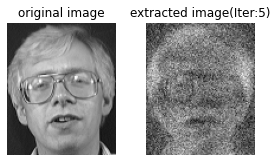

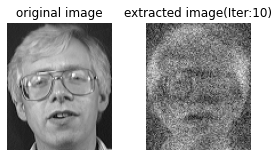

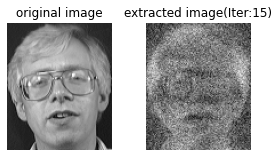

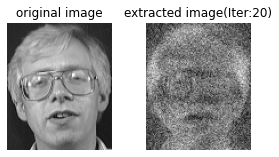

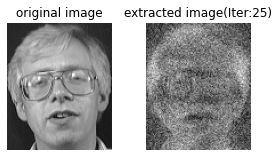

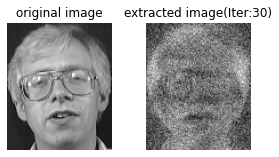

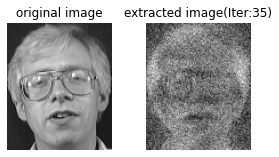

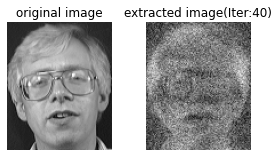

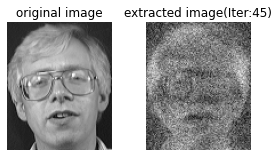

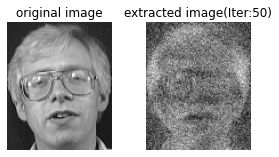

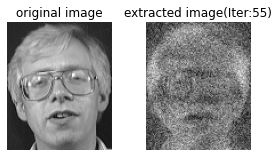

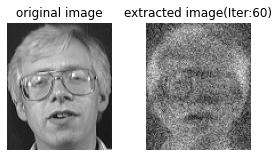

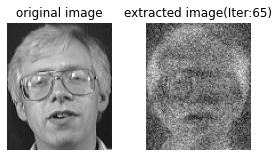

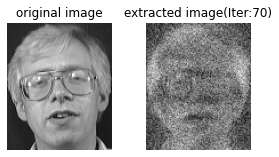

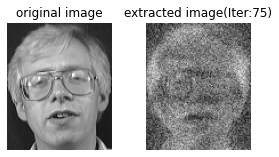

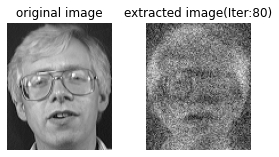

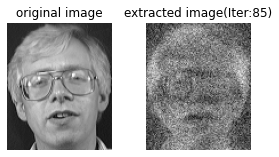

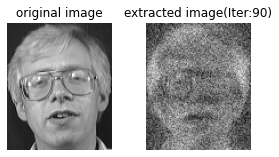

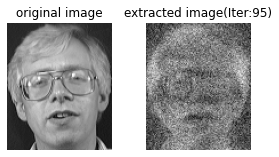

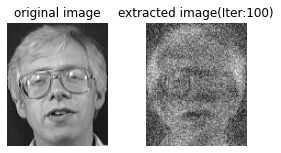

In [ ]:
input_shape = (1, 1, 112, 92)
target_label = 1
lam = 0.1
for num_itr in range(5,101,5):
  mi = MI_FACE(
      netMLP,
      input_shape,
      target_label=target_label,
      num_itr=num_itr,
      lam=lam,
      log_interval=0,
  )
  x_result_1, log = mi.attack()
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))
  axes[0].imshow(cv2.imread(BASE + "s2/1.pgm", 0), cmap="gray")
  axes[0].axis("off")
  axes[0].set_title("original image")
  axes[1].imshow(x_result_1[0][0].detach().numpy(), cmap="gray")
  axes[1].axis("off")
  title = "extracted image(Iter:"+str(num_itr)+")"
  axes[1].set_title(title)
  fig.tight_layout()
  name = "MLP_itr_"+str(num_itr)+".png"
  paths = path+name
  plt.savefig(paths)
  fig.show()
  del mi

<ipython-input-9-02a76f1263e4>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))


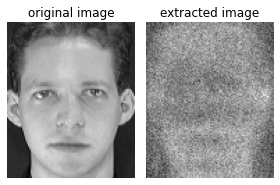

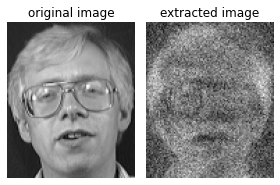

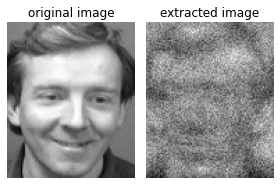

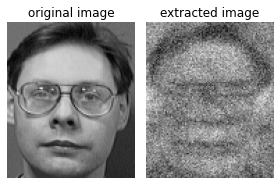

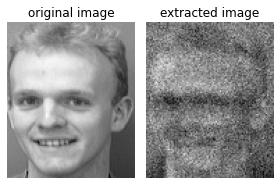

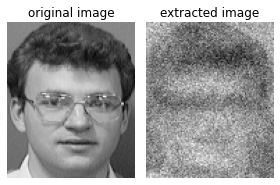

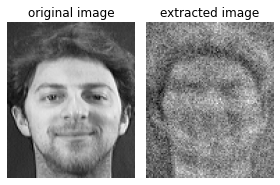

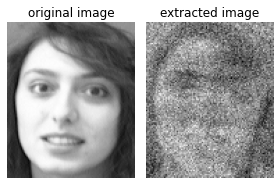

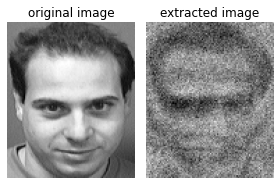

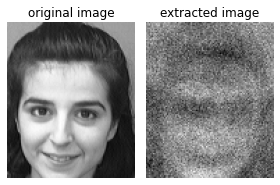

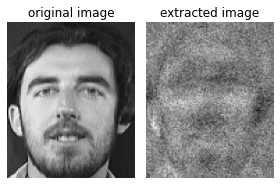

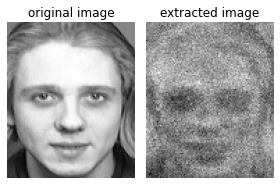

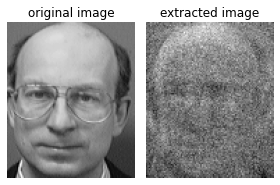

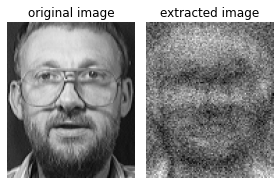

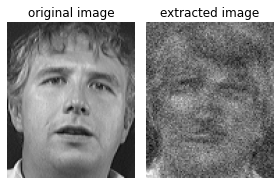

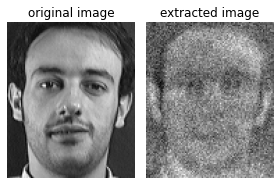

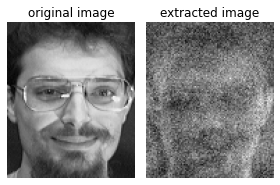

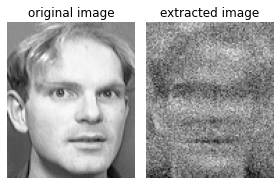

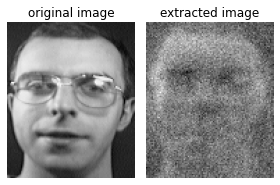

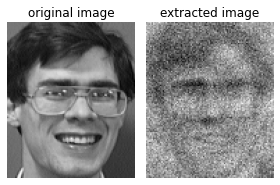

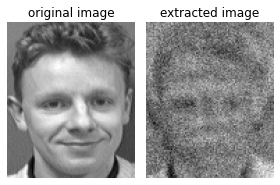

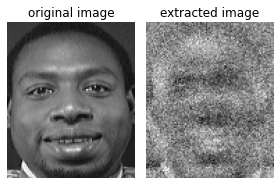

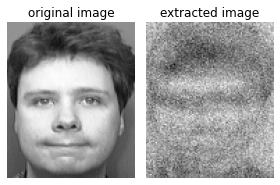

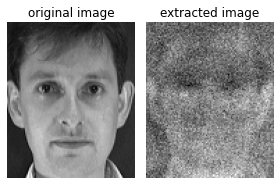

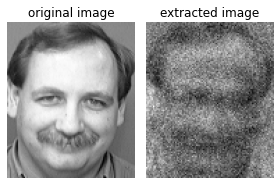

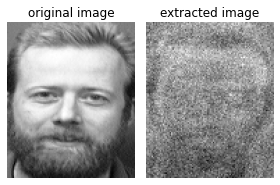

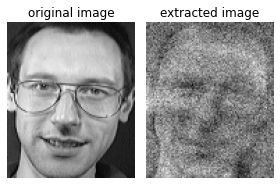

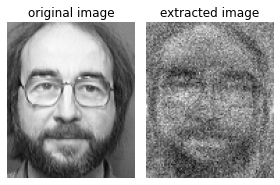

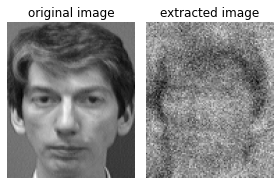

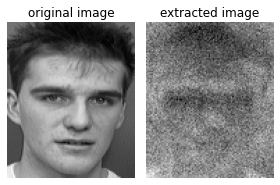

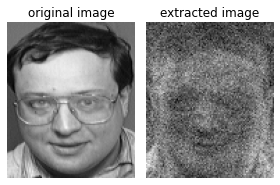

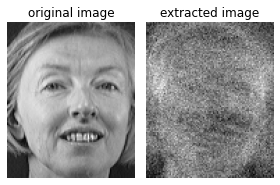

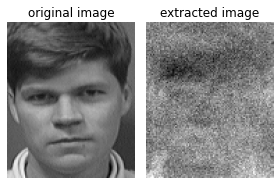

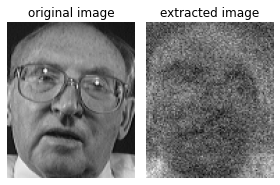

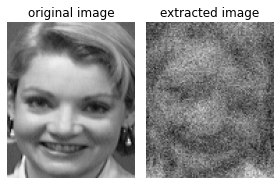

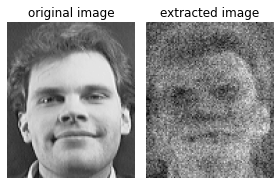

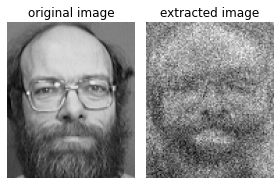

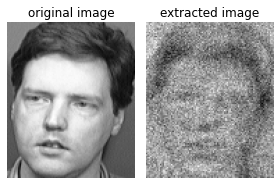

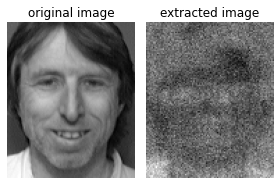

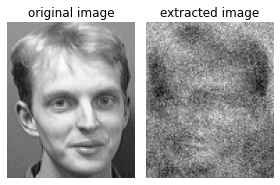

In [ ]:
input_shape = (1, 1, 112, 92)
target_label = 1
lam = 0.1
num_itr = 50
for target_label in range(0,40):
  mi = MI_FACE(
      netMLP,
      input_shape,
      target_label=target_label,
      num_itr=num_itr,
      lam=lam,
      log_interval=0,
  )
  x_result_1, log = mi.attack()
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))
  originalimage = "s"+str(target_label+1)+"/1.pgm"
  axes[0].imshow(cv2.imread(BASE + originalimage, 0), cmap="gray")
  axes[0].axis("off")
  axes[0].set_title("original image")
  axes[1].imshow(x_result_1[0][0].detach().numpy(), cmap="gray")
  axes[1].axis("off")
  axes[1].set_title("extracted image")
  fig.tight_layout()
  name = "MLP_class_"+str(target_label)+".png"
  paths = path+name
  plt.savefig(paths)
  fig.show()
  del mi
  del paths

# Cell 8
# Applying DPSGD defense

In [ ]:
lot_size = 40
batch_size = 1
iterations = 20
sigma = 0.5
l2_norm_clip = 1
delta = 1e-5

accountant = GeneralMomentAccountant(
    noise_type="Gaussian",
    search="ternary",
    precision=0.001,
    order_max=1,
    order_min=72,
    max_iterations=1000,
    bound_type="rdp_upperbound_closedformula",
    backend="python",
)

privacy_manager = DPSGDManager(
    accountant,
    optim.SGD,
    l2_norm_clip=l2_norm_clip,
    dataset=trainset,
    lot_size=lot_size,
    batch_size=batch_size,
    iterations=iterations,
)
accountant.reset_step_info()
accountant.add_step_info(
    {"sigma": sigma},
    lot_size / len(trainset),
    iterations * (len(trainset) / lot_size),
)
estimated_epsilon = accountant.get_epsilon(delta=delta)
print(f"estimated epsilon is {estimated_epsilon}")

accountant.reset_step_info()
dpoptimizer_cls, lot_loader, batch_loader = privacy_manager.privatize(
    noise_multiplier=sigma
)

estimated epsilon is 56.384900436393984


In [ ]:
net = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = dpoptimizer_cls(net.parameters(), lr=0.05, momentum=0.9)

for epoch in range(iterations):  # loop over the dataset multiple times

    running_loss = 0
    data_size = 0
    preds = []
    labels = []

    for X_lot, y_lot in lot_loader(optimizer):
        for X_batch, y_batch in batch_loader(TensorDataset(X_lot, y_lot)):
            optimizer.zero_grad()
            pred = net(X_batch)
            loss = criterion(pred, y_batch.to(torch.int64))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            data_size += X_batch.shape[0]
            preds.append(pred)
            labels.append(y_batch)

    preds = torch.cat(preds)
    labels = torch.cat(labels)
    print(f"epoch {epoch}: loss is {running_loss/data_size}")

print(f"final epsilon is {accountant.get_epsilon(delta=delta)}")

epoch 0: loss is 3.5118159357909184
epoch 1: loss is 2.6817421204314793
epoch 2: loss is 1.7139422471163035
epoch 3: loss is 0.9743574413496134
epoch 4: loss is 0.5149377309605561
epoch 5: loss is 0.36225644488681574
epoch 6: loss is 0.21822942434680864
epoch 7: loss is 0.13383705963947723
epoch 8: loss is 0.06737931618475375
epoch 9: loss is 0.08548240512807258
epoch 10: loss is 0.054731940362342316
epoch 11: loss is 0.026630200120702642
epoch 12: loss is 0.027837523837148728
epoch 13: loss is 0.04597333349864761
epoch 14: loss is 0.03942576369994729
epoch 15: loss is 0.03723347929215905
epoch 16: loss is 0.04213477937276048
epoch 17: loss is 0.03818659363766454
epoch 18: loss is 0.07536875548882813
epoch 19: loss is 0.04678448756161972
final epsilon is 106.44407633896735


In [ ]:
in_preds = []
in_label = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        in_preds.append(outputs)
        in_label.append(labels)
    in_preds = torch.cat(in_preds)
    in_label = torch.cat(in_label)
print(
    "Test Accuracy is: ",
    accuracy_score(np.array(torch.argmax(in_preds, axis=1)), np.array(in_label)),
)

Test Accuracy is:  0.8975


<ipython-input-13-a157ebb9af64>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))


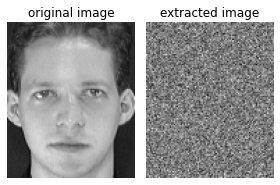

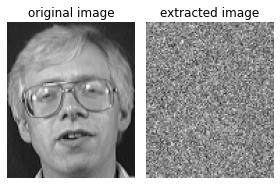

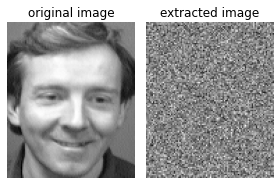

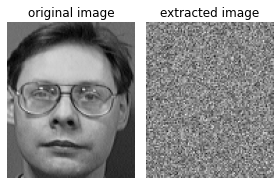

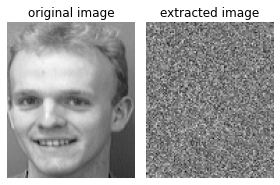

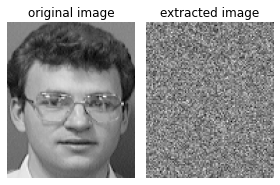

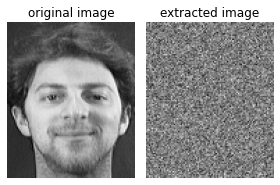

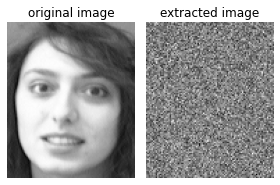

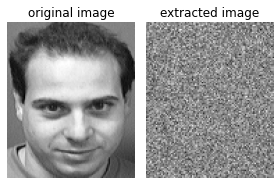

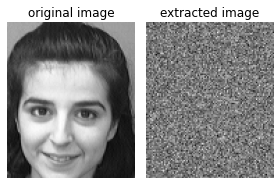

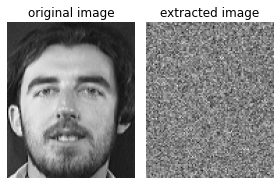

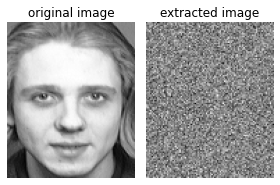

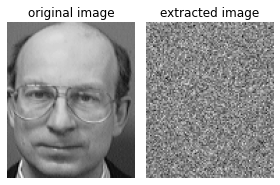

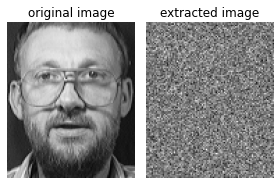

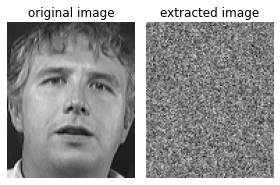

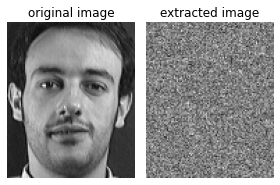

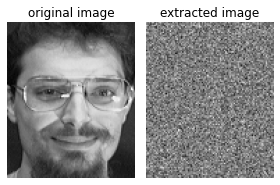

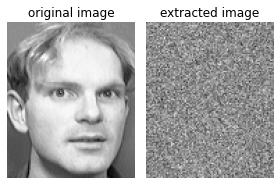

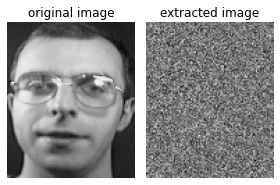

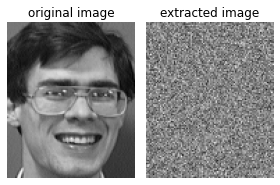

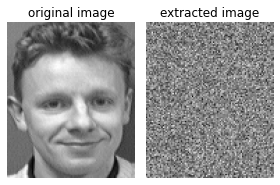

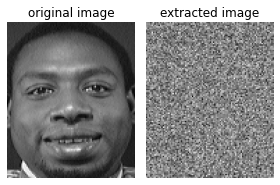

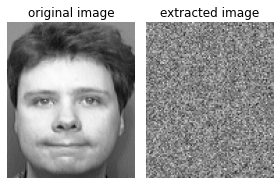

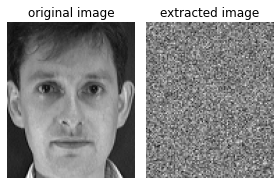

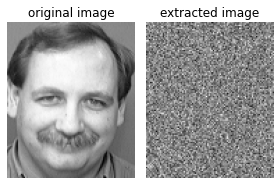

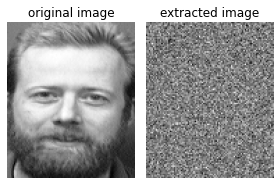

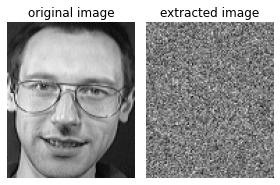

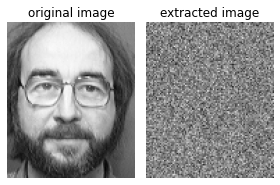

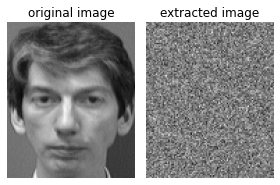

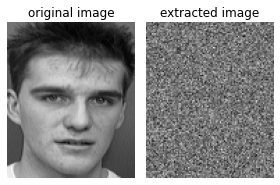

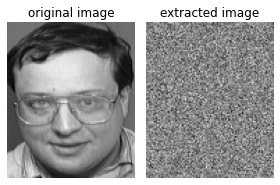

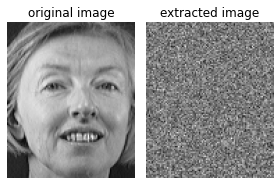

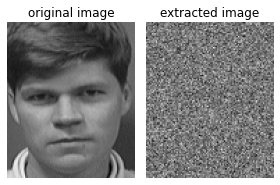

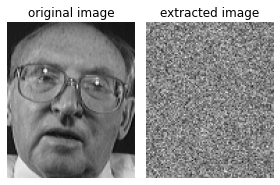

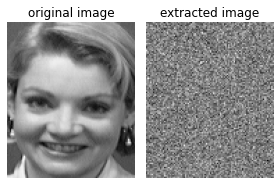

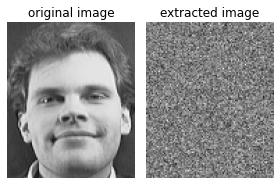

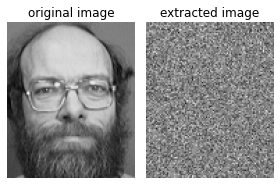

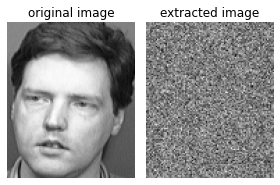

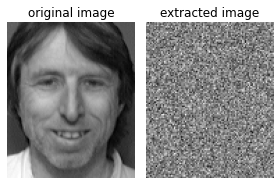

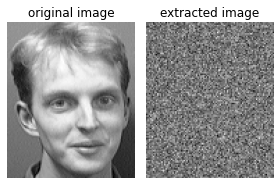

In [ ]:
input_shape = (1, 1, 112, 92)
target_label = 1
lam = 0.1
num_itr = 50
for target_label in range(0,40):
  mi = MI_FACE(
      net,
      input_shape,
      target_label=target_label,
      num_itr=num_itr,
      lam=lam,
      log_interval=0,
  )
  x_result_1, log = mi.attack()
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))
  originalimage = "s"+str(target_label+1)+"/1.pgm"
  axes[0].imshow(cv2.imread(BASE + originalimage, 0), cmap="gray")
  axes[0].axis("off")
  axes[0].set_title("original image")
  axes[1].imshow(x_result_1[0][0].detach().numpy(), cmap="gray")
  axes[1].axis("off")
  axes[1].set_title("extracted image")
  fig.tight_layout()
  name = "MLP_DPSGD_defense"+str(target_label)+".png"
  paths = path+name
  plt.savefig(paths)
  fig.show()
  del mi
  del paths